# Neural network refresher - part 2 - auto differentiation engines

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

## From first principle 

A function of a real variable $f(x)$ is differentiable at a point $a$ of its domain, if its domain contains an open interval $I$ containing $a$ and the limit
$$ L= \lim_{h\to0} \frac{f(a+h) - f(a)}{h} $$
exists. This means that for every positive real number $\epsilon$ (even very small), there exists a positive real number $\delta$ such that, for every such $h$ such that $|h|<\delta$ and $h\neq 0$, then

$$ \left| L - \lim_{h\to0} \frac{f(a+h) - f(a)}{h} \right| < \epsilon$$

In simple words the conditions for a limit to exist are:

1. Approaching the Same Value from Both Sides: The function must approach the same value as you get closer to a specific point from both the left and the right. If the left-hand limit and the right-hand limit are different, the overall limit does not exist.

2. Finite Value: The value that the function approaches must be a finite number. If the function goes to infinity or negative infinity, the limit does not exist.

3. No Oscillations: The function should not oscillate wildly as it approaches the point. If it keeps jumping between different values, the limit does not exist.

If the above conditions for the limit hold true, the value given by the formula is the first derivative $f'(x)$ of the function $f(x)$ at point $a$

## Lets take an example

$f(x)=3x^2-4x+5$

By the [rules](https://en.wikipedia.org/wiki/Differentiation_rules) of differentiation 

$f'(x) = 6x - 4$

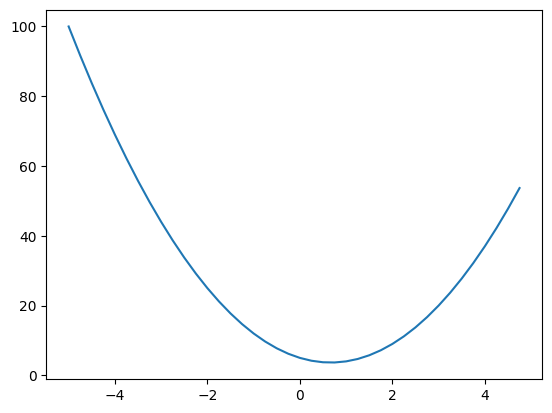

In [4]:
xs = np.arange(-5, 5, 0.25) # [-5, -4.75, -4.5, ..., 4.75]
ys = f(xs)
plt.plot(xs, ys)

### Manually, the derivative at a few points are

In [5]:
h = 0.00000001 # A very small number, well sort of :)
x = [3.0, 2.0, 0.0, -1.0, 2/3]
print((f(x[0]+h)-f(x[0]))/h) # From the first principle formula
print((f(x[1]+h)-f(x[1]))/h) # or we manually calculated the derivative to be 6x - 4
print((f(x[2]+h)-f(x[2]))/h) # So the derivative at x = 0 is - 4
print((f(x[3]+h)-f(x[3]))/h) # The derivate at x = -1 is 10
print((f(x[4]+h)-f(x[4]))/h) # The derivate is 0 at x = 2/3

14.00000009255109
7.999999951380232
-3.999999975690116
-10.000000116860974
0.0


### Note above results have numerical precision error that is not there if we calculate analytically
This error will come up time and time again. If you add too many zeros for example, the internal representation of the numbers are messed up

In [7]:
h = 0.00000000000000000001
print((f(x[0]+h)-f(x[0]))/h) # x[0] is 3.0, overflow happens
h = 0.000001 # Thus h can't be too small in our calculation
print((f(x[0]+h)-f(x[0]))/h) 

0.0
14.000003002223593


## Let us consider another example

In [8]:
a = 2.0
b = -3.0
c = 10
d = a*b + c
print(d)

4.0


### $ab+c$

In [9]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10

d1 = a*b + c
a  = a + h # nudging a by a small amount
d2 = a*b + c

print('d1 = ', d1) # a*b + c
print('d2 = ', d2) # (a+h)*b + c

d1 =  4.0
d2 =  3.999699999999999


$b$ is a negative number. Adding $h$ to $a$ slightly increases the value of $a$. Since $b$ is negative, we are adding, overall less to $c$ which brings the value of the result down by a tiny amount
This indicates the slope (change) would be negative hence the result went down in value

In [9]:
print('slope = ', (d2-d1)/h) # f(a+h) - f(a) / h, here we are differentiating with respect to a

slope =  -3.000000000010772


Similarly if we now increase the value of $b$ slightly, we see the slope is positive, indicating the result has increased in value

In [10]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10

d1 = a*b + c
b  = b + h # nudging a by a small amount
d2 = a*b + c

print('d1 = ', d1) # a*b + c
print('d2 = ', d2) # a*(b+h) + c
print('slope = ', (d2-d1)/h) # f(b+h) - f(b) / h, here we are differentiating with respect to b

d1 =  4.0
d2 =  4.0002
slope =  2.0000000000042206


## Neural networks are massive objects in computer memory. To store them efficiently, we need some kind of data structure
### Let us now look at one such implementation, the overall structure and functionality of the following class closely resembles libraries like pytorch

In [12]:
class Value:
    def __init__(self, data):
        self.data = data
    def __repr__(self): # returns a representation of the object when we print it
        return f"Value(data={self.data})"

a = Value(2.0)
a # internally calls a.__repr__()

Value(data=2.0)

In [13]:
a = Value(2.0)
b = Value(-3.0)
a + b

TypeError: unsupported operand type(s) for +: 'Value' and 'Value'

### We want to support mathematical operations in our Value class
Let us again modify the class to add some methods

In [14]:
class Value:
    def __init__(self, data):
        self.data = data
    def __repr__(self): # returns a representation of the object when we print it
        return f"Value(data={self.data})"
    def __add__(self, other): # python internally calls this method when we use the + operator
        out = Value(self.data + other.data)
        return out

a = Value(2.0)
b = Value(-3.0)
a + b # internally calls a.__add__(b)

Value(data=-1.0)

### Great addition works now. Now we implement multiply

In [15]:
class Value:
    def __init__(self, data):
        self.data = data
    def __repr__(self): # returns a representation of the object when we print it
        return f"Value(data={self.data})"
    def __add__(self, other): # python internally calls this method when we use the + operator
        out = Value(self.data + other.data)
        return out
    def __mul__(self, other): # python internally calls this method when we use the * operator
        out = Value(self.data * other.data)
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10)
a * b # internally calls a.__mul__(b)
## and then
a*b + c

Value(data=4.0)

### This is the same as

In [16]:
a.__mul__(b).__add__(c)

Value(data=4.0)

## Great. Neural netoworks are big graph like expressions. Thus we need some kind of connective tissue which binds all the Value objects together into a big graph structure
### Let us now modify the Value class

In [17]:
class Value:
    def __init__(self, data, _children=()): # _children is a private variable with default value of empty tuple
        self.data = data
        self._prev = set(_children) # set of previous nodes

    def __repr__(self): 
        return f"Value(data={self.data})"
    def __add__(self, other): 
        
        out = Value(self.data + other.data, (self, other)) # feeding the cause of result as new node's children
        return out
    def __mul__(self, other): 
        
        out = Value(self.data * other.data, (self, other)) # new node's children are self and other
        return out

a = Value(2.0)
b = Value(-3.0)
e = a*b
c = Value(10)
d = e + c
print(d)
print(d._prev) # one child for c and one child for a*b i.e e
print(e._prev) # a and b are the parents of e

Value(data=4.0)
{Value(data=-6.0), Value(data=10)}
{Value(data=-3.0), Value(data=2.0)}


### Now we know what children created a specific Value. But we don't know what operation created them. Thus we modify the class once again to keep track of the operator when new values are created

In [18]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''): # _op is empty for leaves
        self.data = data
        self._prev = set(_children) # set of previous nodes
        self._op = _op # operation performed to get this node
        self.label = label

    def __repr__(self): 
        return f"Value(data={self.data})"
    def __add__(self, other): 
        
        out = Value(self.data + other.data, (self, other), '+') # feeding the cause of result as new node's children
        return out
    def __mul__(self, other): 
        
        out = Value(self.data * other.data, (self, other), '*') # new node's children are self and other
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
e = a*b; e.label = 'e'
c = Value(10, label='c')
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
print(L)
print(f"L._prev: {L._prev}, L._op = {L._op}") # one child for d and one child for f
print(f"d._prev: {d._prev}, d._op = {d._op}") # one child for c and one child for a*b i.e e
print(f"r._prev: {e._prev}, r._op: {e._op}") # a and b are the parents of e
print(f"a._op: {a._op}") # a is a leaf node, so no operation performed on it

Value(data=-8.0)
L._prev: {Value(data=-2.0), Value(data=4.0)}, L._op = *
d._prev: {Value(data=10), Value(data=-6.0)}, d._op = +
r._prev: {Value(data=-3.0), Value(data=2.0)}, r._op: *
a._op: 


## Situation is getting out of hand. We need some kind of visual representation

In [19]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in the graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # Left to right graph

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name=uid, label= "{ %s | data %.4f }" % (n.label, n.data), shape='record') 

    if n._op: # will work for non empty _op for every node, e.g for e, d, L 
      dot.node(name=uid + n._op, label= n._op ) # creating a node for the operation
      dot.edge(uid + n._op, uid) # connecting the operation (oval) node to the Value [rectangle] node

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op) # connecting the parent to the child with the operation, if there is any

  return dot

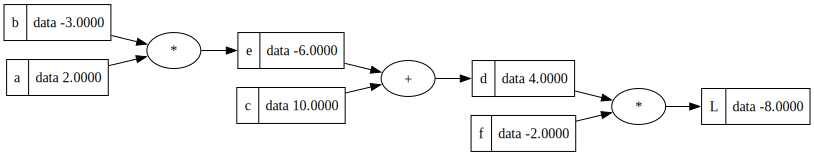

In [20]:
draw_dot(L)

### Now we are interested in finding out how much does the loss change if we change any of the nodes in the graph
### I.e We need to find
### $\frac{\partial{L}}{\partial{d}}$, $\frac{\partial{L}}{\partial{f}}$, $\frac{\partial{L}}{\partial{e}}$
Finding this out is done through a process known as backpropagation\
$a,b,c$ are inputs. And inputs are fixed. Thus 
### $\frac{\partial{L}}{\partial{a}} = 0$, $\frac{\partial{L}}{\partial{b}}=0$, $\frac{\partial{L}}{\partial{c}}=0$
### Let us modify the Value class once again to add another property, which holds the derivative, or rather the gradient of the loss $L$ with respect to each of the Value nodes

We also modify our graph visualisation methods, so we see a gradient corresponding to the Values in the graph

In [21]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in the graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # Left to right graph
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name=uid, label= "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')  # added grad to the node 

    if n._op: # will work for non empty _op for every node, e.g for e, d, L 
      dot.node(name=uid + n._op, label= n._op ) # creating a node for the operation
      dot.edge(uid + n._op, uid) # connecting the operation (oval) node to the Value [rectangle] node

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op) # connecting the parent to the child with the operation, if there is any

  return dot

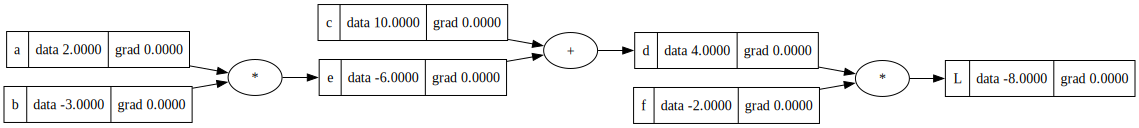

In [22]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''): # _op is empty for leaves
        self.data = data
        self.grad = 0.0 # gradient of the node, initialized to 0
        # 0 means no effect. So we assume at initialization, every value does not effect the output
        self._prev = set(_children) 
        self._op = _op 
        self.label = label

    def __repr__(self): 
        return f"Value(data={self.data})"
    def __add__(self, other): 
        
        out = Value(self.data + other.data, (self, other), '+') 
        return out
    def __mul__(self, other): 
        
        out = Value(self.data * other.data, (self, other), '*') 
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
draw_dot(L)

### First let us fill in the gradients manually and do backpropagation

1. How much does $L$ change if we take the derivative of $L$ with respect to itself?
2. What about $a$?
3. What about $d$?
4. What about other Values?

Let us test it out with the first principle formula

In [23]:
def dL_dL():
  h = 0.0001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d*f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d*f; L.label = 'L'
  L2 = L.data + h # nudging L2 by a small amount

  print(f"Derivative of L with respect to itself: {(L2 - L1)/h}")

def dL_da():  
  # Lets do it with respect to a

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d*f; L.label = 'L'
  L1 = L.data

  a = Value(2.0 + h, label='a') # nudging a by a small amount
  b = Value(-3.0, label='b')
  c = Value(10, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d*f; L.label = 'L'
  L2 = L.data

  print(f"Derivative of L with respect to a: {(L2 - L1)/h}")

def dL_db():
  # Lets do it with respect to b

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d*f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0 + h, label='b') # nudging b by a small amount
  c = Value(10, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d*f; L.label = 'L'
  L2 = L.data

  print(f"Derivative of L with respect to b: {(L2 - L1)/h}")

def dL_dc():
  # Lets do it with respect to c

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d*f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10 + h, label='c') # nudging c by a small amount
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d*f; L.label = 'L'
  L2 = L.data

  print(f"Derivative of L with respect to c: {(L2 - L1)/h}")

def dL_df():
  # Lets do it with respect to f

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d*f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0 + h, label='f') # nudging f by a small amount
  L = d*f; L.label = 'L'
  L2 = L.data

  print(f"Derivative of L with respect to f: {(L2 - L1)/h}")

def dL_dd():
  # Lets do it with respect to d

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d*f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  d = Value(d.data + h, label='d') # nudging d by a small amount
  f = Value(-2.0, label='f')
  L = d*f; L.label = 'L'
  L2 = L.data

  print(f"Derivative of L with respect to d: {(L2 - L1)/h}")

def dL_de():
  # Lets do it with respect to e

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d*f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10, label='c')
  e = a*b; e.label = 'e'; e.data += h # nudging e by a small amount
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d*f; L.label = 'L'
  L2 = L.data

  print(f"Derivative of L with respect to e: {(L2 - L1)/h}")

def derivative():
  dL_dL()
  dL_da()
  dL_db()
  dL_dc()
  dL_dd()
  dL_de()
  dL_df()

derivative()

Derivative of L with respect to itself: 0.9999999999976694
Derivative of L with respect to a: 6.000000000021544
Derivative of L with respect to b: -4.000000000008441
Derivative of L with respect to c: -1.9999999999953388
Derivative of L with respect to d: -1.9999999999953388
Derivative of L with respect to e: -1.9999999999953388
Derivative of L with respect to f: 3.9999999999995595


Thus we can manually set $L.grad=1$ 

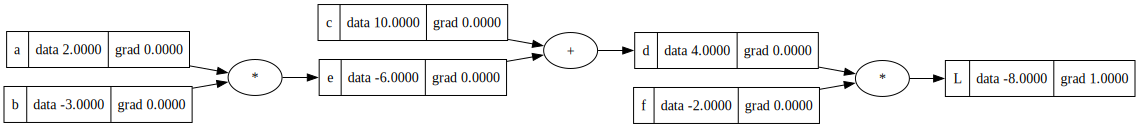

In [24]:
L.grad = 1.0 # setting the gradient of L to 1
draw_dot(L)

Good. We know $L=d\times f$, and we are interested to find how much does L change when we change d, i.e $\frac{dL}{dd}$. By multiplication rule of derivatives, we can calculate $\frac{dL}{dd} = \frac{d\ (f\times d)}{dd} = f$

### Or from the first principles $\frac{dL}{dd} = \frac{f(x+h) - f(x)}{h}$

### $ \text{or ‎ ‎ ‎ ‎ ‎ ‎  } \frac{ (d+h)\times f - d\times f}{h}\ \text{‎ ‎ ‎ ‎ } [\because f(x) = d\times f, f(x+h) = (d+h)\times f]$

### $\text{or ‎ ‎ }\frac{df + dh - df}{h}\\ \text{or ‎ ‎ ‎   }\frac{hf}{h}\\ \text{or ‎ ‎ ‎ ‎ ‎ }f $

### Thus $f.grad$ will be the value of $d$
### Similarly, $d.grad$ will be the value of $f$

### $\text{Hence we can say that a multiplication operation just copies the value of other's data in current value's gradient}$

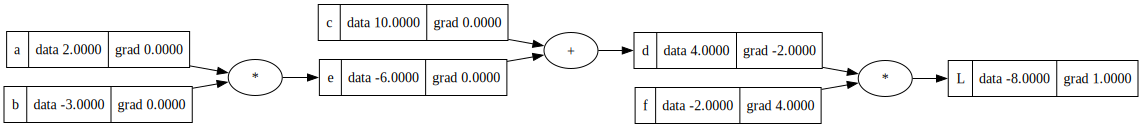

In [25]:
f.grad = d.data # 4.0
d.grad = f.data # -2.0
draw_dot(L)

### What would be the contribution of change in c to the change in d? In other words what would $\frac{dd}{dc}$ be?

Again from the first principle we can derive,

### $d = c+e$

### $\frac{((c+h)+e) - (c+e)}{h} \text{‎ ‎ ‎ ‎ } [\because f(x+h) = (c+h)+e]$

### $\frac{dd}{dc} = 1.0$, and by symmetry,  $\frac{dd}{de} = 1.0$

### However these are local gradients. I.e it is not the gradient of $L$ with respect to $c$ and $e$

### Now, we want to know what is the effect of change in $c$ as how much it changes $L$. 
### What we know: $\frac{dL}{dd}$, $\frac{dd}{dc}$ and $\frac{dd}{de}$
### What we want: $\frac{dL}{dc}$ and $\frac{dL}{de}$

### From chain rule we know: 

### - When a variable $z$ depends on a variable $y$, which in turn depends on another variable $x$, change in $z$ with respect to change in $x$ is given by:
### $\frac{dz}{dx}=\frac{dz}{dy}\cdot\frac{dy}{dx}$

### In simple words: If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels $2\times 4 = 8$ times as fast as the man

### Hence the gradients $\frac{dL}{dc}$ and $\frac{dL}{de}$ can be written as:

### $\frac{dL}{dc} =\frac{dL}{dd} \times \frac{dd}{dc} $ and   $\frac{dL}{de} = \frac{dL}{dd} \times \frac{dd}{de} $

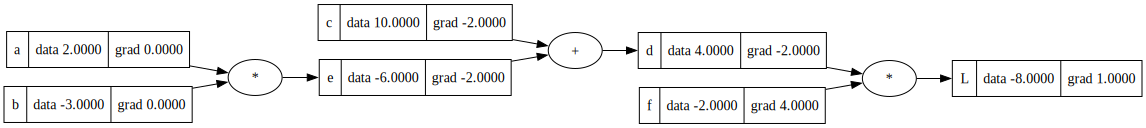

In [26]:
c.grad = d.grad * 1.0
e.grad = d.grad * 1.0
draw_dot(L)

## Important note

### Since we calculated the local gradient of a plus node to be always $1$. We say all a plus operator does, is route the gradients from parent to its children.
### Thus $\frac{dL}{dd} \times \frac{dd}{dc} $ will be just $\frac{dL}{dd}$

### Great. Similarly we apply chain rule one more time
### We want $\frac{dL}{da}$, we know $\frac{dL}{de}$ (we just calculated) and $\frac{de}{da}$ (which is the local gradient)
### $\frac{de}{da} = b \text{‎ ‎ } [\because e=a\cdot b ]$ 
### By chain rule $\frac{dL}{da} = \frac{dL}{de}\cdot \frac{de}{da}$

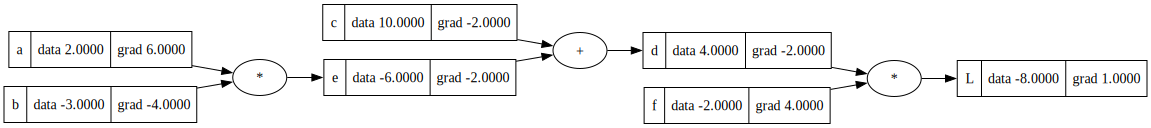

In [27]:
a.grad = e.grad * b.data
# similarly
b.grad = e.grad * a.data
draw_dot(L)

# What we just did, was the manual backpropagation of gradients from the end (Loss function result) to the beginning (inputs)
## What will happen if we nudge the leaf nodes by a tiny amount towards their gradient?

-7.286496


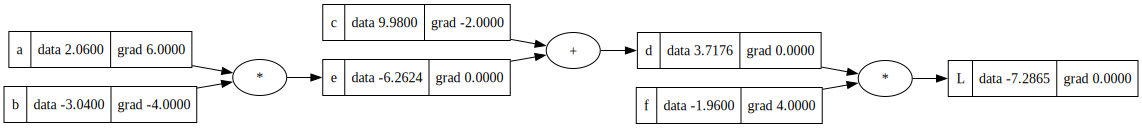

In [28]:
h = 0.01
a.data += h*a.grad # nudging a.data by a small amount
b.data += h*b.grad # nudging b.data by a small amount
c.data += h*c.grad # nudging c.data by a small amount
f.data += h*f.grad # nudging f.data by a small amount
# Also don't forget to do the forward pass again
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
L = d*f; L.label = 'L'
# Note because e,d and L are dependent on a,b,c and f, we need to update them as well
# And we lost their gradient values, so we need to do the backward pass again to find the new gradients
print(L.data)
draw_dot(L)

### We just performed a single optimisation step

# Now let us look at a more practical example of a neuron



| Biological Neuron | Mathematical object Neuron | Neural Network |
|---------|---------|---------|
| ![nerve](./img/nervous-system.jpg) | ![neuron](./img/neuron.jpeg)  | ![neuralNet](./img/neural-network.png)


### Let us look at an activation function: $tanh$

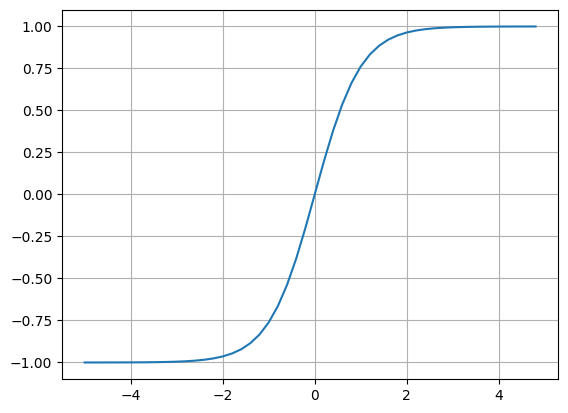

In [29]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid() # Activation function tanh squishes the input between -1 and 1

Now let us look at neuron

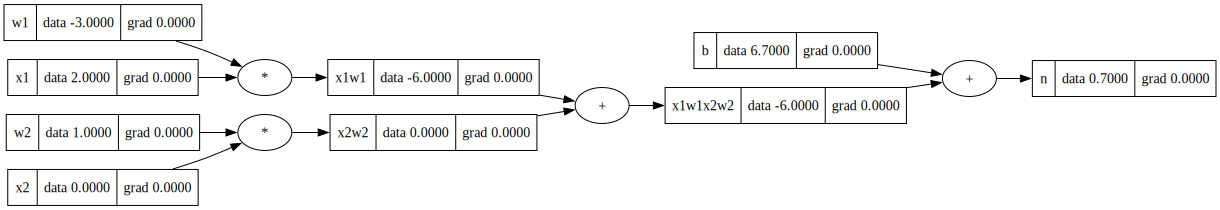

In [29]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron b
b = Value(6.7, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# we still can't do n.tanh() because we haven't implemented the tanh function in our Value class
draw_dot(n)

The $n$ here is the ouput before the activation function. But right now our Value class doesn't support any kind of activation function. Let's add $tanh$ to our value class

Remember $tanh$ is defined as (One of the definitions) $$\frac{e^{2x}-1}{e^{2x}+1}$$

In [30]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''): # _op is empty for leaves
        self.data = data
        self.grad = 0.0 # gradient of the node, initialized to 0
        # 0 means no effect. So we assume at initialization, every value does not effect the output
        self._prev = set(_children) 
        self._op = _op 
        self.label = label

    def __repr__(self): 
        return f"Value(data={self.data})"
    def __add__(self, other): 
        
        out = Value(self.data + other.data, (self, other), '+') 
        return out
    def __mul__(self, other): 
        
        out = Value(self.data * other.data, (self, other), '*') 
        return out
    def tanh(self): # as long as we know how to calculate the local gradient of tanh, we can implement it
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh') # unary operation
        return out

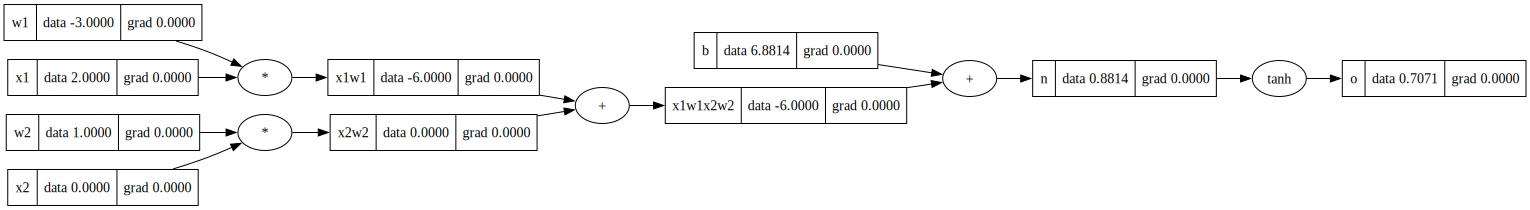

In [31]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron b
b = Value(6.881373, label='b') # specific value to make the the gradients nice
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

### Now we start backpropagating

Derivative of $o$ with respect to itself is $1$.
What is the derivative of $o$ with respect to $n$?

$$\frac{do}{dn}$$

Derivative of $tanh(x)$ is given by $$1-tanh^2(x)$$
But $tanh=o$. Therefore 
$$\frac{do}{dn}=\frac{d(tanh(n))}{dn}=1-tanh^2(x)=1-o^2$$

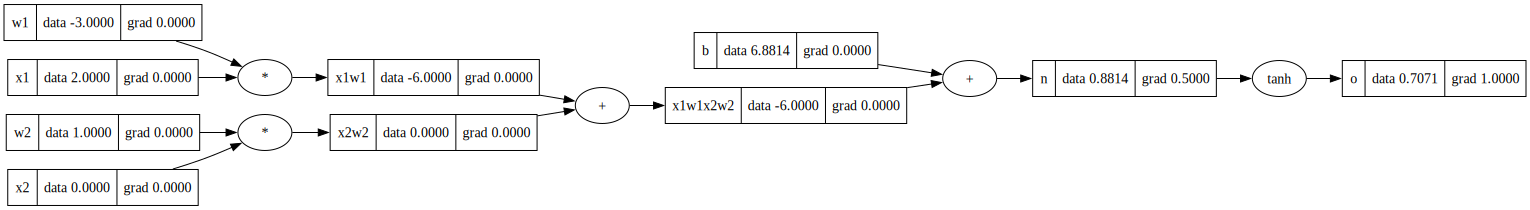

In [32]:
o.grad = 1.0 # setting the gradient of o to 1
n.grad = o.grad * (1 - o.data**2) # tanh'(x) = 1 - tanh^2(x)
draw_dot(o)

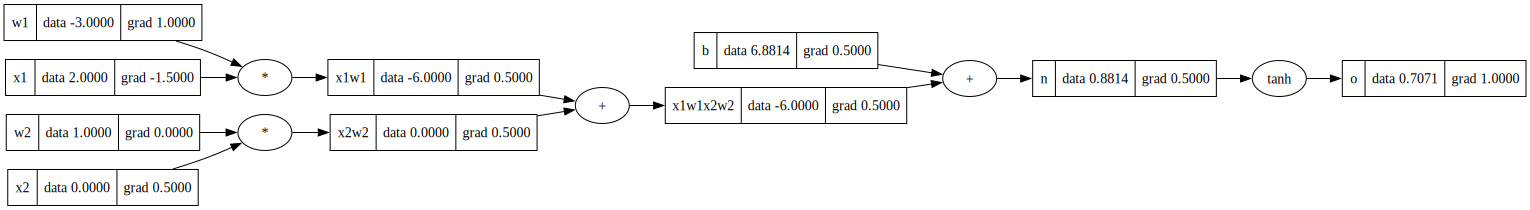

In [33]:
# Similarly for the other nodes
b.grad = n.grad * 1.0
x1w1x2w2.grad = n.grad * 1.0
x2w2.grad = x1w1x2w2.grad * 1.0
x1w1.grad = x1w1x2w2.grad * 1.0
w2.grad = x2w2.grad * x2.data
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
x1.grad = x1w1.grad * w1.data
draw_dot(o)

Because we are multiplying $x2$ and $w2$, and since $x2$ is $0$, it indicates that no matter how much we wiggle or change $w2$, $w2$ has no contribution for the final output to change because it is multiplied by $x2$ which is $0$

# Automatic differentiation

### Differentiating manually through the graph is extremely tedious. What we want is to do the differentiation automatically. We change our value class once again

In [34]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''): # _op is empty for leaves
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # empty function by default to calculate the gradient of the node
        self._prev = set(_children) 
        self._op = _op 
        self.label = label

    def __repr__(self): 
        return f"Value(data={self.data})"
    
    def __add__(self, other): 
        out = Value(self.data + other.data, (self, other), '+') 
        # we want to take out's grad and propagate it to self's grad and other's grad
        # in general, we multiply the local derivative with the derivative which has propagated
        # from the last (rightmost) node
        def _backward():
            self.grad += 1.0 * out.grad # 1 is the local derivative of the addition operation
            other.grad += 1.0 * out.grad # out.grad is the derivative propagated from the last node
        out._backward = _backward

        return out
    
    def __mul__(self, other):     
        out = Value(self.data * other.data, (self, other), '*') 
        def _backward():
            self.grad += other.data * out.grad # other.data is the local derivative of the multiplication operation
            other.grad += self.data * out.grad # self.data is the local derivative of the multiplication operation
            # out.grad is the derivative propagated from the last node
        out._backward = _backward
        return out
    
    def tanh(self): 
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh') 

        def _backward():
            self.grad += (1 - t**2) * out.grad # 1 - tanh^2(x) is the local derivative of tanh, out.grad is the derivative propagated from the last node
        out._backward = _backward
        return out

In [35]:
# Redifining the graph with the new Value class
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron b
b = Value(6.881373, label='b') # specific value to make the the gradients nice
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

### Now we need to call the `_backward()` function in the right order for all the nodes. Note: $o$ should have gradient = $1$ (as our base case).

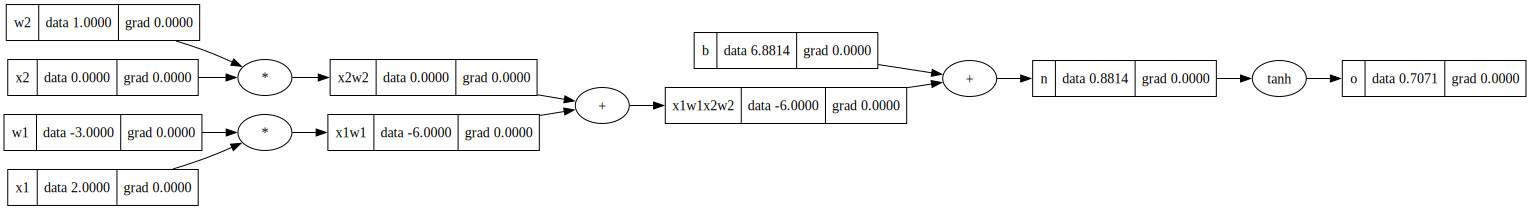

In [36]:
draw_dot(o)

In [37]:
o.grad = 1.0 # setting the gradient of o to 1
o._backward() # calculating the gradient of all the nodes
n._backward()
b._backward() # empty lambda function, so nothing happens
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()
w2._backward()
w1._backward()
x2._backward()
x1._backward()


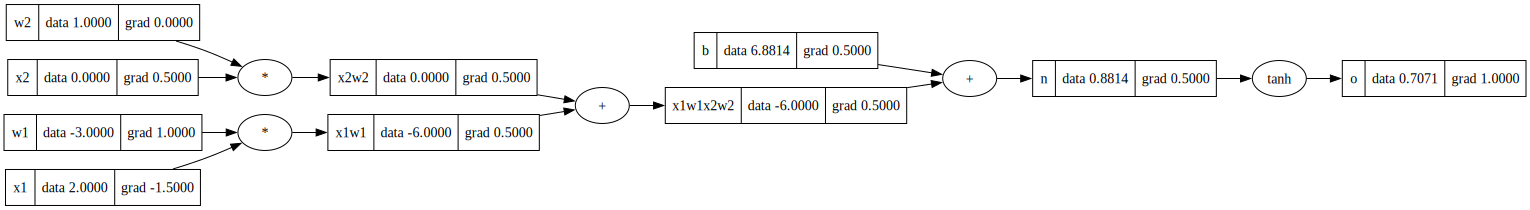

In [38]:
draw_dot(o)

## We see that the gradient can't propagate backwards if all of its dependencies are not calculated first. For a graph this can be achieved using a topological sort.
### Another example for this kind of ordering: Suppose you want to install a package $xyz$ from the package manager. But $xyz$ needs package $abc$ and $hij$ to be installed first. Further, package $abc$ needs another package $pqr$ to be installed first. So the correct ordering of the packages to be installed would be

 $ \{pqr \rarr abc\ ||\ hij\} \rarr xyz$

In simple terms, think of it as a flat 1D ordering of the vertices of a 2D graph

| Topological sort of a Directed Asyclic Graph |
|----------------------------------------------|
|       ![topo-sort](./img/topo-sort.png)          |

Now we want to implement topological sort in our Value class. In a topological sort of a graph (or rather here, a Directed Asyclic Graph, DAG), all the edges go from left to right. 

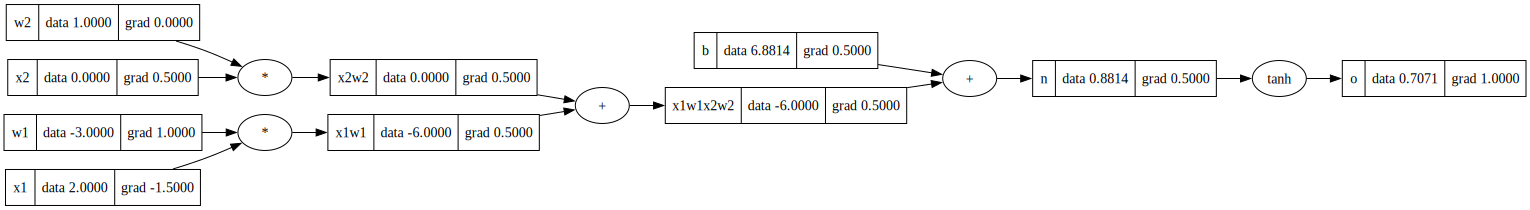

In [39]:
draw_dot(o)

In [40]:
# Topological sort
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
        build_topo(child)
    topo.append(v)
build_topo(o)
# a vertex is only going to be on the list, if all its children are already on the list
print('Topological order:', end=' ')
for v in topo:
    print(v.label, end=', ') # note we need to do backward pass on the reverse order of this list

Topological order: b, w2, x2, x2w2, w1, x1, x1w1, x1w1x2w2, n, o, 

Now with all the building blocks in place, let's modify the Value class one more time to include this automatic backward pass

In [42]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''): # _op is empty for leaves
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # empty function by default to calculate the gradient of the node
        self._prev = set(_children) 
        self._op = _op 
        self.label = label

    def __repr__(self): 
        return f"Value(data={self.data})"
    
    def __add__(self, other): 
        out = Value(self.data + other.data, (self, other), '+') 
        # we want to take out's grad and propagate it to self's grad and other's grad
        # in general, we multiply the local derivative with the derivative which has propagated
        # from the last (rightmost) node
        def _backward():
            self.grad += 1.0 * out.grad # 1 is the local derivative of the addition operation
            other.grad += 1.0 * out.grad # out.grad is the derivative propagated from the last node
        out._backward = _backward

        return out
    
    def __mul__(self, other):     
        out = Value(self.data * other.data, (self, other), '*') 
        def _backward():
            self.grad += other.data * out.grad # other.data is the local derivative of the multiplication operation
            other.grad += self.data * out.grad # self.data is the local derivative of the multiplication operation
            # out.grad is the derivative propagated from the last node
        out._backward = _backward
        return out
    
    def tanh(self): 
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh') 

        def _backward():
            self.grad += (1 - t**2) * out.grad # 1 - tanh^2(x) is the local derivative of tanh, out.grad is the derivative propagated from the last node
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()

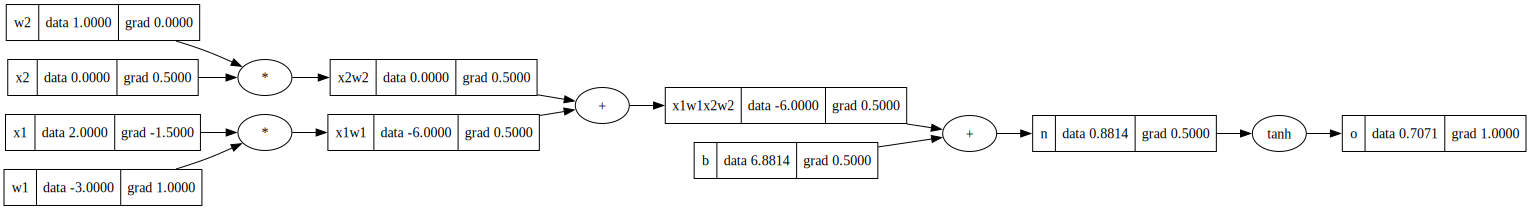

In [43]:
# Redifining the graph with the new Value class
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron b
b = Value(6.881373, label='b') # specific value to make the the gradients nice
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

### Parallels with pytorch

## PyTorch is a very popular library to build neural networks and train them. Let's look at how pytorch's semantics matches with what we wrote

In [44]:
import torch
x1 = torch.Tensor([2.0]).double();   x1.requires_grad = True # by default requires_grad is False for efficiency reasons
x2 = torch.Tensor([0.0]).double();   x2.requires_grad = True # we need to set it to True to calculate the gradients
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True # main difference between our library and pytorch is pytorch is much more efficient
w2 = torch.Tensor([1.0]).double();  w2.requires_grad = True # it can do operations in parallel, vectorized operations
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())

o.backward()

print("-----------------")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.7071066904050358
-----------------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
